In [1]:
import tskit
import numpy as np
import random
from tqdm.notebook import tqdm
import pandas as pd
import msprime
import matplotlib.pyplot as plt

In [2]:
from runsmc import liknb

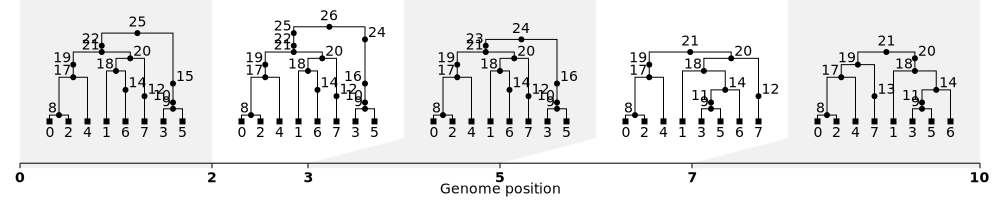

In [3]:
# Simple test example for polytomy making
ets = msprime.sim_ancestry(4, sequence_length=10, recombination_rate=0.05, record_full_arg=True, random_seed=12, model="smc")
ets.draw_svg(time_scale="rank")

Internal: 15	Del: 1


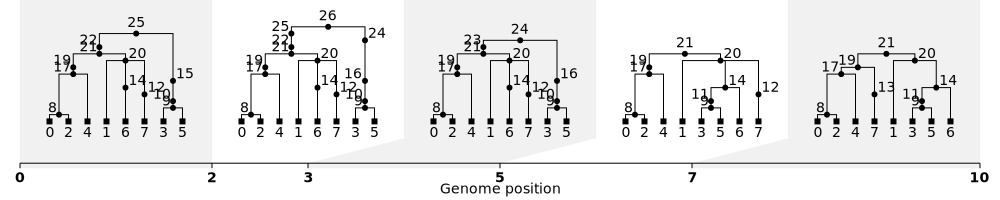

In [4]:
def naive_polytomy_maker(ts, del_nodes):
    del_nodes = set(del_nodes)
    assert len(set(ts.samples()) & del_nodes) == 0
    tables = ts.dump_tables()
    tables.edges.clear()
    for tree in ts.trees():
        assert tree.root not in del_nodes
        for node in tree.nodes():
            if node not in del_nodes:
                parent = tree.parent(node)
                while parent != tskit.NULL:
                    if parent not in del_nodes:
                        tables.edges.add_row(tree.interval.left, tree.interval.right, parent, node)
                        break
                    parent = tree.parent(parent)
    tables.sort()
    tables.edges.squash()
    tables.sort()
    return tables.tree_sequence()

def remove_internal_nodes(ts, fraction, rng):
    roots = set(tree.root for tree in ts.trees())
    #RE_nodes = np.where((ts.nodes_flags & msprime.NODE_IS_RE_EVENT) > 0)[0]
    #print(RE_nodes)
    # internal = set(range(ts.num_nodes)) - (set(RE_nodes) | roots | set(ts.samples()))
    # NOTE we originally kept the RE nodes, but it turns out that this places a strong
    # limit on how many polytomies we get because there's so much recombination. Removing
    # coalescent node doesn't creat a polytomy if there's a unary node on the branch
    # above it.
    internal = set(range(ts.num_nodes)) - (roots | set(ts.samples()))
    #print(internal)
    del_nodes = rng.sample(list(internal), int(len(internal) * fraction))
    print(f"Internal: {len(internal)}\tDel: {len(del_nodes)}")
    return naive_polytomy_maker(ts, del_nodes)

rng = random.Random(42)
tsp = remove_internal_nodes(ets, 0.1, rng)
#tsp = naive_polytomy_maker(ts, [11])
tsp.draw_svg(time_scale="rank")

In [5]:
def simplify_keeping_unary_in_coal(ts, map_nodes=False):
    """
    Keep the unary regions of nodes that are coalescent at least someone in the tree seq
    Temporary hack until https://github.com/tskit-dev/tskit/issues/2127 is addressed
    """
    tables = ts.dump_tables()
    # remove existing individuals. We will reinstate them later
    tables.individuals.clear()
    tables.nodes.individual = np.full_like(tables.nodes.individual, tskit.NULL)

    _, node_map = ts.simplify(map_nodes=True)
    keep_nodes = np.where(node_map != tskit.NULL)[0]
    # Add an individual for each coalescent node, so we can run
    # simplify(keep_unary_in_individuals=True) to leave the unary portions in.
    for u in keep_nodes:
        i = tables.individuals.add_row()
        tables.nodes[u] = tables.nodes[u].replace(individual=i)
    node_map = tables.simplify(keep_unary_in_individuals=True, filter_individuals=False)

    # Reinstate individuals
    tables.individuals.clear()
    for i in ts.individuals():
        tables.individuals.append(i)
    val, inverted_map = np.unique(node_map, return_index=True)
    inverted_map = inverted_map[val != tskit.NULL]
    tables.nodes.individual = ts.tables.nodes.individual[inverted_map]
    if map_nodes:
        return tables.tree_sequence(), node_map
    else:
        return tables.tree_sequence()

In [6]:
NE = 10000
MU = 1.25e-8
REC = 1.25e-8
SEQLEN = 1_000_000
seed = 4977
n = 100

full_arg = msprime.sim_ancestry(
        samples = n,
        record_full_arg=True,
        recombination_rate=REC,
        population_size=NE,
        sequence_length=SEQLEN,
        random_seed=seed,
        model='smc'
        )


In [7]:
full_arg

In [8]:
unary_coal =  simplify_keeping_unary_in_coal(full_arg)
unary_coal

In [9]:
fully_simplified = full_arg.simplify()
fully_simplified

In [10]:
inputs = {
    "full_arg_smc": full_arg,
    "unary_coal": unary_coal,
    "fully_simplified": fully_simplified
}
poly_inputs = {}

In [11]:

poly_inputs = {}
rng = random.Random(42)
for poly_frac in [0.05, 0.25]:
    for name, ts in inputs.items():        
        tsp = remove_internal_nodes(ts, poly_frac, rng)
        key = f"poly_{name}_{poly_frac}"
        print(key, ts.num_edges, tsp.num_edges, sep="\t")
        poly_inputs[key] = tsp
        #dest[poly_fract] = tsp
    

Internal: 8501	Del: 425
poly_full_arg_smc_0.05	13221	12788
Internal: 2455	Del: 122
poly_unary_coal_0.05	6901	6812
Internal: 2455	Del: 122
poly_fully_simplified_0.05	10674	10673
Internal: 8501	Del: 2125
poly_full_arg_smc_0.25	13221	11092
Internal: 2455	Del: 613
poly_unary_coal_0.25	6901	6387
Internal: 2455	Del: 613
poly_fully_simplified_0.25	10674	11123


In [12]:
poly_inputs

{'poly_full_arg_smc_0.05': <tskit.trees.TreeSequence at 0x7f85037d7070>,
 'poly_unary_coal_0.05': <tskit.trees.TreeSequence at 0x7f85037d6ef0>,
 'poly_fully_simplified_0.05': <tskit.trees.TreeSequence at 0x7f85037d40a0>,
 'poly_full_arg_smc_0.25': <tskit.trees.TreeSequence at 0x7f85037d6290>,
 'poly_unary_coal_0.25': <tskit.trees.TreeSequence at 0x7f85037d4610>,
 'poly_fully_simplified_0.25': <tskit.trees.TreeSequence at 0x7f85037d7040>}

# Running tsinfer on the input

In [13]:
import tsinfer
import tsdate

In [14]:
full_arg_muts = msprime.sim_mutations(full_arg, rate=MU)
full_arg_muts

In [15]:
sd = tsinfer.SampleData.from_tree_sequence(full_arg_muts)

In [16]:
tsi_ts = tsinfer.infer(sd)

In [17]:
tsi_ts_dated = tsdate.date(tsi_ts, mutation_rate=MU, allow_unary=True)
tsi_ts_dated

AttributeError: module 'tskit.provenance' has no attribute 'get_resources'

In [ ]:
tsi_ts_dated_fs = tsdate.date(tsi_ts.simplify(), mutation_rate=MU)
tsi_ts_dated_fs

In [ ]:
inputs["tsinfer_tsdate"] = tsi_ts_dated
inputs["tsinfer_fs_tsdate"] = tsi_ts_dated_fs

# Polytomy statistics

In [ ]:
poly_data = []
for key, ts in {**inputs, **poly_inputs}.items():
    #arity = np.zeros(ts.num_trees)
    #poly_count = np.zeros(ts.num_trees)
    leaves = np.zeros(ts.num_trees)
    unary = np.zeros(ts.num_trees)
    binary = np.zeros(ts.num_trees)
    poly = np.zeros(ts.num_trees)
    for tree in ts.trees():
        preorder = tree.preorder()
        num_children = tree.num_children_array[tree.preorder()]
        leaves[tree.index] = np.sum(num_children == 0)
        unary[tree.index] = np.sum(num_children == 1)
        binary[tree.index] = np.sum(num_children == 2)
        poly[tree.index] = np.sum(num_children > 2)
    # Note: means are slightly off here for tsinfer'd ones because the 
    # first and last trees are missing data
    poly_data.append({"name": key, "leaves": np.mean(leaves),
                      "unary": np.mean(unary),
                      "binary": np.mean(binary),
                      "poly": np.mean(poly)})
df_poly = pd.DataFrame(poly_data)
df_poly

# Likelihood surface for recombination rate

In [ ]:
data = []
re_values = [REC] + list(np.logspace(-9, -7, num=40))

for rho in tqdm(re_values):
    ll = msprime.log_arg_likelihood(full_arg, rho, NE)
    datum = {"rho": rho, "full_arg_hudson": ll}
    for name, ts in {**inputs, **poly_inputs}.items():
        datum[name] = liknb.log_likelihood(ts, rho, NE)
    data.append(datum) 

In [ ]:
df = pd.DataFrame(data).set_index("rho")
df

In [ ]:
df.to_csv("likelihood_surface.csv")

In [ ]:
# Convert to ratio. Pretty arbitrary what we do here, but it doesn't seem to 
# make any difference to the plotted output, just changes the scales.
df_rat = df.iloc[1:].copy()
for col in list(df_rat):
    df_rat[col] -= df.iloc[0][col]
    df_rat[col] *= -1
    #df_rat[col] /= df.iloc[0][col]

In [ ]:
colours = {
    "full_arg_smc": "tab:red",
    "unary_coal": "tab:blue",
    "fully_simplified": "tab:orange",
    "full_arg_hudson": "tab:purple",
    "tsinfer_tsdate": "tab:green",
    "tsinfer_fs_tsdate": "tab:olive",

}
titles = {
    "full_arg_smc": "Full ARG (SMC)",
    "unary_coal": "Unary coalescent",
    "fully_simplified": "Fully simplified",
    "full_arg_hudson": "Full ARG (HKY)",
    "tsinfer_tsdate": "tsinfer+tsdate",
    "tsinfer_fs_tsdate": "tsinfer+tsdate (fully simplified)",
}

def finish_plot():
    plt.annotate("True parameter", xy=(REC, 1.1), xytext=(-80, 0), textcoords="offset points")    
    plt.axvline(REC, linestyle='dashed', color="grey")
    plt.xlabel("Recombination rate")
    plt.ylabel("Relative log likelihood")
    
x = df_rat.index
for col in [col for col in df if not col.startswith("poly")]:
    line = plt.semilogx(x, df_rat[col], label=titles[col], color=colours[col])

finish_plot()
plt.legend();  


In [ ]:
import matplotlib.lines as mlines

line_styles = {
    "0": "solid",
    "0.05": "dashed",
    "0.25": "dotted",
}

ls_patches = [
    mlines.Line2D([0], [0], color="black", lw=1, ls=ls, 
        label=f"{float(label):.0%}")
    for label, ls in line_styles.items()
]

x = df_rat.index
for col in df_rat: 
    if col.startswith("poly"):
        splits = col.split("_")
        arg = "_".join(splits[1:-1])
        poly = splits[-1]
    else:
        continue
        if col == "full_arg_hudson":
            continue
        arg = col
        poly = "0"
    
    y = df_rat[col] - df_rat[arg]
    line = plt.semilogx(x, y, color=colours[arg], ls=line_styles[poly],
                        label="_nolegend_" if poly != "0" else titles[arg])
  
finish_plot()
legend1 = plt.legend()
plt.legend(handles=ls_patches, loc="lower left", title="Polytomies");  
plt.gca().add_artist(legend1);
plt.ylim(-100, 2000)
#plt.xlim(5e-9, 5e-8)
